![Cabec%CC%A7alho_notebook.png](cabecalho_notebook.png)

# Classificação de Atividade Humana com PCA

Vamos trabalhar com a base da demonstração feita em aula, mas vamos explorar um pouco melhor como é o desempenho da árvore variando o número de componentes principais.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [2]:
filename_features = "./features.txt"
filename_labels = "./activity_labels.txt"

filename_subtrain = "./train/subject_train.txt"
filename_xtrain = "./train/X_train.txt"
filename_ytrain = "./train/y_train.txt"

filename_subtest = "./test/subject_test.txt"
filename_xtest = "./test/X_test.txt"
filename_ytest = "./test/y_test.txt"

features = pd.read_csv(filename_features, header=None, names=['nome_var'], sep="#")
features = features['nome_var']  
labels = pd.read_csv(filename_labels, delim_whitespace=True, header=None, names=['cod_label', 'label'])

subject_train = pd.read_csv(filename_subtrain, header=None, names=['subject_id'])
X_train = pd.read_csv(filename_xtrain, delim_whitespace=True, header=None)  
y_train = pd.read_csv(filename_ytrain, header=None, names=['cod_label'])

subject_test = pd.read_csv(filename_subtest, header=None, names=['subject_id'])
X_test = pd.read_csv(filename_xtest, delim_whitespace=True, header=None) 
y_test = pd.read_csv(filename_ytest, header=None, names=['cod_label'])

## PCA com variáveis padronizadas

Reflexão sobre a escala das variáveis:

**Variáveis em métricas muito diferentes** podem interferir na análise de componentes principais. Lembra que variância é informação pra nós? Pois bem, tipicamente se há uma variável monetária como salário, vai ter uma ordem de variabilidade bem maior que número de filhos, tempo de emprego ou qualquer variável dummy. Assim, as variáveis de maior variância tendem a "dominar" a análise. Nesses casos é comum usar a padronização das variáveis.

Faça duas análises de componentes principais para a base do HAR - com e sem padronização e compare:

- A variância explicada por componente
- A variância explicada acumulada por componente
- A variância percentual por componente
- A variância percentual acumulada por componente
- Quantas componentes você escolheria, em cada caso para explicar 90% da variância?

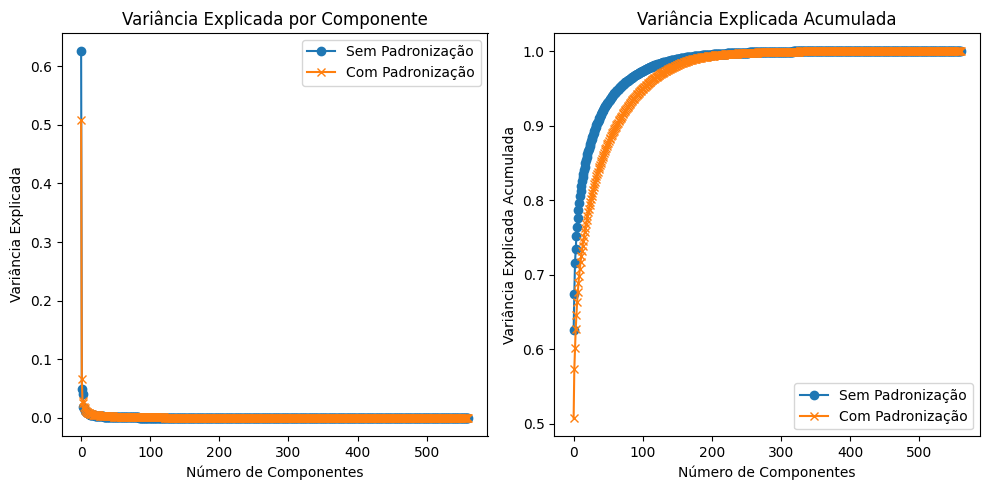

Componentes necessários para explicar 90% da variância (sem padronização): 34
Componentes necessários para explicar 90% da variância (com padronização): 63


In [3]:
def padroniza(s):
    if s.std() > 0:
        s = (s - s.mean()) / s.std()
    return s

X_train_pad = pd.DataFrame(X_train).apply(padroniza, axis=0)

pca_scaled = PCA()
pca_scaled.fit(X_train_pad)

explained_variance_scaled = pca_scaled.explained_variance_ratio_
cumulative_variance_scaled = np.cumsum(explained_variance_scaled)

pca = PCA()
pca.fit(X_train)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(explained_variance, marker='o', label='Sem Padronização')
plt.plot(explained_variance_scaled, marker='x', label='Com Padronização')
plt.title('Variância Explicada por Componente')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cumulative_variance, marker='o', label='Sem Padronização')
plt.plot(cumulative_variance_scaled, marker='x', label='Com Padronização')
plt.title('Variância Explicada Acumulada')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.legend()

plt.tight_layout()
plt.show()

components_for_90_var = np.argmax(cumulative_variance >= 0.90) + 1
components_for_90_var_scaled = np.argmax(cumulative_variance_scaled >= 0.90) + 1

print(f"Componentes necessários para explicar 90% da variância (sem padronização): {components_for_90_var}")
print(f"Componentes necessários para explicar 90% da variância (com padronização): {components_for_90_var_scaled}")


## Árvore com PCA

Faça duas uma árvore de decisão com 10 componentes principais - uma com base em dados padronizados e outra sem padronizar. Utilize o ```ccp_alpha=0.001```.

Compare a acurácia na base de treino e teste.

In [4]:
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

X_train_pad_pca = pca.fit_transform(X_train_pad)
X_test_pad_pca = pca.transform(pd.DataFrame(X_test).apply(padroniza, axis=0))

tree_model = DecisionTreeClassifier(ccp_alpha=0.001)
tree_model_pad = DecisionTreeClassifier(ccp_alpha=0.001)

tree_model.fit(X_train_pca, y_train)
y_train_pred = tree_model.predict(X_train_pca)
y_test_pred = tree_model.predict(X_test_pca)

tree_model_pad.fit(X_train_pad_pca, y_train)
y_train_pred_pad = tree_model_pad.predict(X_train_pad_pca)
y_test_pred_pad = tree_model_pad.predict(X_test_pad_pca)

acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)

acc_train_pad = accuracy_score(y_train, y_train_pred_pad)
acc_test_pad = accuracy_score(y_test, y_test_pred_pad)

print(f"Acurácia na base de treino sem padronização: {acc_train}")
print(f"Acurácia na base de teste sem padronização: {acc_test}")

print(f"Acurácia na base de treino com padronização: {acc_train_pad}")
print(f"Acurácia na base de teste com padronização: {acc_test_pad}")

Acurácia na base de treino sem padronização: 0.8926822633297062
Acurácia na base de teste sem padronização: 0.8242280285035629
Acurácia na base de treino com padronização: 0.8586779107725789
Acurácia na base de teste com padronização: 0.7740074652188667
